# Get and explore dataset

In [215]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
# import pad_sequences
from tensorflow.keras.preprocessing import sequence

#used to define the network architecture and beyond
from tensorflow.keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import LSTM, SpatialDropout1D, BatchNormalization, Dense

# import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [216]:
# Make results reproducible - set random seed
from numpy.random import seed
seed(42)

In [217]:
negative_file = "negative.txt"
positive_file = "positive.txt"

In [218]:
# Do not modify - helper function to load and preprocess data
def filter_words(line):    
    line = re.sub(r'[^\w\s]','',line.rstrip())
    words = line.split(" ") 
    words = [i.lower() for i in words if i]      
    return " ".join(words)

def load_data(filename):
    thefile = open(filename, 'r') 
    lines = thefile.readlines() 

    data = []
    for l in range(0,len(lines)): 
        if(lines[l-1].strip() == "<title>"): 
            theline = filter_words(lines[l])
            if(len(theline) < 50):
                data.append(theline)            
            
    return data

# Helper function to convert categorical data to class label
def to_word_label(y):
    y = to_class(y)   
    return ["positive" if i==0 else "negative" for i in y]

# Helper function to convert class label to numeric label
def to_numeric_label(y):
  return [0 if i=="positive" else 1 for i in word_labels]

# Helper function: this function needs to be called before sending arrays to sklearn metrics,
# it converts back to class form from categorical form. ie: [1,0] --> 0, [0,1] --> 1
def to_class(y):
    return np.argmax(y,axis=1) 

In [219]:
positive = load_data(positive_file)
negative = load_data(negative_file)

print(positive[0:10])
print(negative[0:10])

['one of the best crichton novels', 'the medicine of the future', 'beautiful', 'for lovers of robicheaux', 'a good book', 'to the point and beautifully illustrated', 'at least somebody has got it', 'beautifully written heartwarming story', 'an excellent cookbook full of delicious recipes', 'an outstanding resource']
['horrible book horrible', 'shallow selfindulgence', 'horrible book horrible', 'disappointment', 'a disappointing mess', 'save your money there are better books out there', 'thank you but no thanks', 'unendurable', 'the hard way', 'some good info among the political commercial']


In [220]:
# Do not modify - Combines the positive and negative reviews into a single list and create labels
data = positive + negative
word_labels = ["positive"] * len(positive) + ["negative"] * len(negative) 

# Converts labels to numbers in one-hot encoding - [1, 0] (positive) or [0, 1] (negative)
from tensorflow.keras.utils import to_categorical
labels  = to_categorical(to_numeric_label(word_labels))

Mean review size is : 24.676519799219186 characters
Standard deviation is : 11.284051928842775 characters


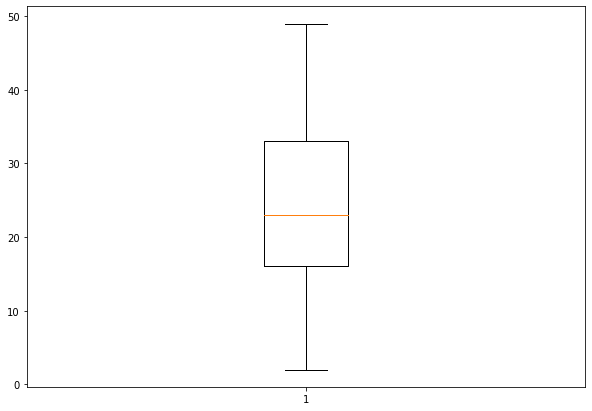

Unique words are 1676


In [221]:
# Write some code to investigate the dataset. 
# - Calculate and report the mean review size, its standard deviation and create a boxplot.
review_length = []
for item in data:
    review_size = len(item)
    review_length.append(review_size)
    
data_mean = sum(review_length) / len(review_length)
variance = sum([((x - mean) ** 2) for x in review_length]) / len(review_length)
standard_deviation = variance ** 0.5

print(f'Mean review size is : {data_mean} characters')
print(f'Standard deviation is : {standard_deviation} characters')

# converting list to array
arr = np.array(review_length)
fig = plt.figure(figsize =(10, 7)) 
# Creating plot
plt.boxplot(arr) 
# show plot
plt.show()

# - Calculate the number of unique words in the dataset
# By definition, sets only contain unique elements, so when the list is converted to a set all duplicates are removed. 
print(f'Unique words are {len(set(data))}')

# - Perform any other dataset investigation that you feel would be valuable

 

There are 46037 words in the combination of all reviews.


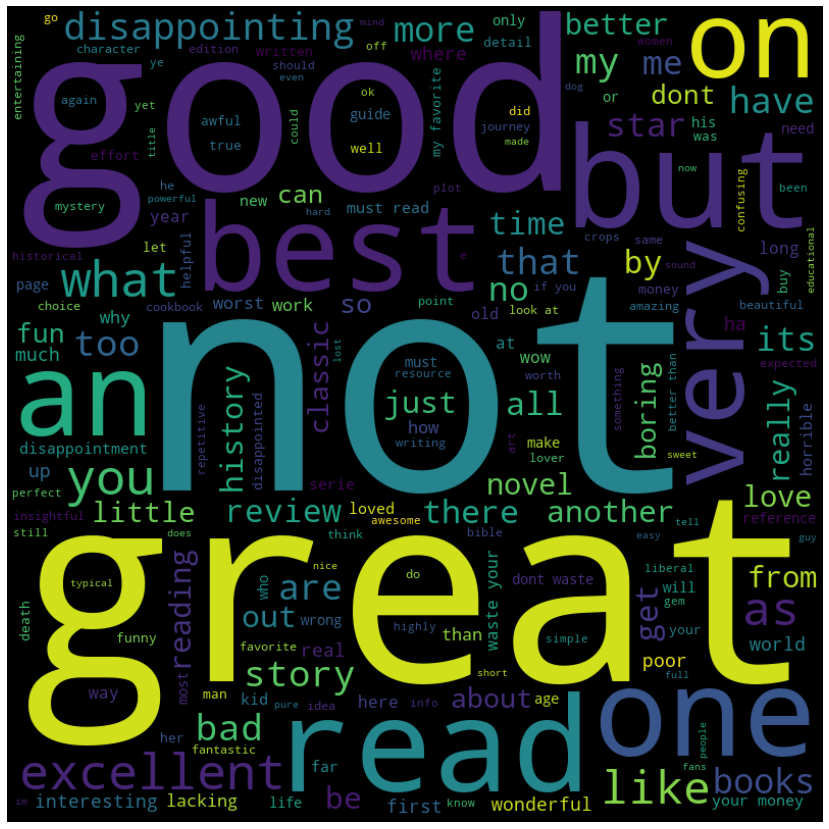

In [222]:
# Additional dataset investigations
#Create text for the wordcloud from the dataset as string
text = " ".join(data)
print ("There are {} words in the combination of all reviews.".format(len(text)))
#Generate and display the wordcloud
plt.subplots(figsize=(15,15))
# exclude common words
stop_words = ["a", "book", "The", "the", "this", "of", "for", "to", "i", "it", "is", "and", "with", "in"]
wordcloud = WordCloud(stopwords = stop_words, width = 800, height = 800, margin = 10).generate(text)

plt.imshow(wordcloud ,interpolation='bilinear')
plt.axis('off')
plt.savefig('graph.png')

plt.show()

The words "not", "good" and "great" are most common in the reviews. 

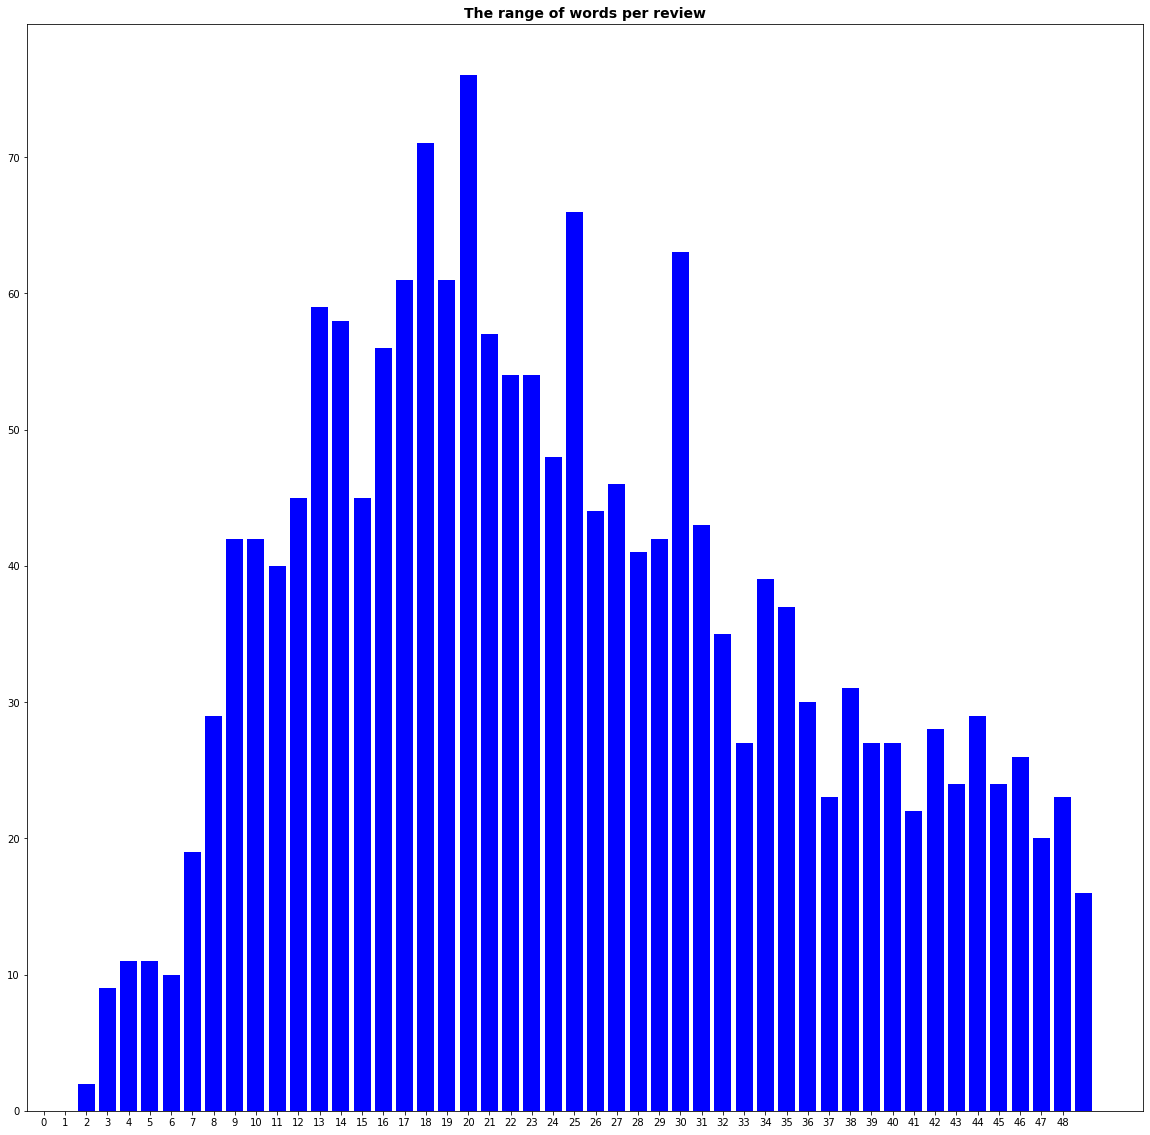

In [223]:
# Display a bar graph of the no words per review
plt.figure(figsize = (20,20))
unique, counts = np.unique(arr, return_counts=True)

plt.bar(unique, counts, color = "blue")
plt.title("The range of words per review", weight='bold', size=14)
plt.xticks(np.arange(0, len(unique)+1, 1))
plt.show()


The number of words in most reviews is 20, with over 70 reviews having 20 words. 

In [224]:
# Do not modify - Tokenize the vocabulary 
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=25)

tokenizer.fit_on_texts(data) #create the vocabularry

tokenized_data = tokenizer.texts_to_sequences(data) #tokenize the data using the vocabulary

vocab_size = len(tokenizer.word_index) + 1 

# Compare a sample of the data before and after tokenization
print(data[0:5])
print(tokenized_data[0:5])

['one of the best crichton novels', 'the medicine of the future', 'beautiful', 'for lovers of robicheaux', 'a good book']
[[18, 4, 2, 19], [2, 4, 2], [], [6, 4], [1, 12, 3]]


# Pre-processing

In [225]:
# Pre-processing
# Write some code to pre-process the data so that each review is the same length
# set max length to 20 due to the length of words in the sentences being <= 20 
maxlen = 49

# Set X_data
pad_dataX = pad_sequences(tokenized_data , maxlen=maxlen)


Since the tokenized data is the positive and negative reviews combined. We know that the top parts are the positive reviews and the rest are negative. Using this information, I created dataframes and assigned dummy values where 0 = positive and 1 = negative review. Then concatenate that into a single dataframe with corresponding token and review to get the X and Y with no shape errors

In [226]:
# create list from positive reviews = [1,0]
'''
for positive results, 1 will be in first index while 0 will be in the second index
this is because of using the softmax function
'''
# list to store the values
pos = []

# loop for positive reviews
for pos_rev in range(len(positive)):
    pos.append([1,0])

# convert to an array
pos = np.array(pos)
    

# create list from negative reviews = [0,1]
'''
for negative results, 0 will be in first index while 1 will be in the second index
this is because of using the softmax function
'''
# list to store the values
neg = []

# loop for positive reviews
for neg_rev in range(len(negative)):
    neg.append([0,1])

# convert to an array
neg = np.array(neg)


# and stack them together
stack = (pos,neg)
pad_dataY = (np.concatenate(stack))

In [227]:
# Write some code to split the data into a training and test set. Make sure you shuffle the data. Use 20% for the test set.
#code below splits the data into a training and test set. 

# Assign the data
X = pad_dataX
Y = pad_dataY

# split the data 80% train, 20% test and set shuffle True
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

# display the shape of the data
print('X_train shape: ',X_train.shape)
print('Y_train shape: ',Y_train.shape)
print('X_test shape: ',X_test.shape)
print('Y_test shape: ',Y_test.shape)

print('\nThe current train data:\n',X_train)
print('\nThe current test data:\n',X_test)



X_train shape:  (1434, 49)
Y_train shape:  (1434, 2)
X_test shape:  (359, 49)
Y_test shape:  (359, 2)

The current train data:
 [[ 0  0  0 ... 23  2  4]
 [ 0  0  0 ...  0  4 11]
 [ 0  0  0 ...  2  8  6]
 ...
 [ 0  0  0 ...  0 21  9]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

The current test data:
 [[ 0  0  0 ...  0  0  8]
 [ 0  0  0 ...  0 10  4]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  3 21  5]
 [ 0  0  0 ...  0  0 20]
 [ 0  0  0 ...  0  0  0]]


In [228]:

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

# Fill in the following function so it
# - makes a prediction for the test set given the model
# - reports the precision, recall and f1 score. Also print the confusion matrix. 
# You will need to use the helper to_class function to convert y_pred and y_test before supplying them to the sklearn functions.

def assess_model(model, X_test, y_test):
    # make predictions
    Y_pred = model.predict(X_test)
        
    # confusion matrix
    Y_pred = to_class(Y_pred)
    y_test = to_class(y_test)    
    
    cm = confusion_matrix(y_test, Y_pred)
    print("Confusion Matrix:")
    print("{}".format(cm))
    
    # Classification Report
    cr = classification_report(y_test, Y_pred, zero_division= 0)
    print("Classification Report:")
    print("{}".format(cr))

# Build and tune model

Define network architecture

In [229]:
# create instance of the model
model = Sequential()

# add the layers
'''
input_dim has to be vocab sizedue to the model having to remember the tokens
input_length has to be maxlen (the sentence vectors of the tokenized words)
''' 
embedding_layer = Embedding(input_dim=vocab_size, output_dim=2 , input_length=maxlen)
model.add(embedding_layer)
model.add(SpatialDropout1D(0.2))
model.add(BatchNormalization())
model.add(LSTM(32))
model.add(Dense(2, activation='softmax'))

Train model

In [230]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy']
             )
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 49, 2)             5120      
                                                                 
 spatial_dropout1d_7 (Spatia  (None, 49, 2)            0         
 lDropout1D)                                                     
                                                                 
 batch_normalization_7 (Batc  (None, 49, 2)            8         
 hNormalization)                                                 
                                                                 
 lstm_7 (LSTM)               (None, 32)                4480      
                                                                 
 dense_7 (Dense)             (None, 2)                 66        
                                                                 
Total params: 9,674
Trainable params: 9,670
Non-traina

Examine performance of model

In [231]:
# Fit the data to the model
batch_size = 10
epochs = 5

history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2 )

Epoch 1/5
115/115 [==============================] - 3s 11ms/step - loss: 0.6933 - accuracy: 0.5013 - val_loss: 0.6918 - val_accuracy: 0.5331
Epoch 2/5
115/115 [==============================] - 1s 8ms/step - loss: 0.6841 - accuracy: 0.5632 - val_loss: 0.6881 - val_accuracy: 0.5366
Epoch 3/5
115/115 [==============================] - 1s 8ms/step - loss: 0.6665 - accuracy: 0.5824 - val_loss: 0.6753 - val_accuracy: 0.5958
Epoch 4/5
115/115 [==============================] - 1s 8ms/step - loss: 0.6608 - accuracy: 0.5763 - val_loss: 0.6570 - val_accuracy: 0.6167
Epoch 5/5
115/115 [==============================] - 1s 8ms/step - loss: 0.6531 - accuracy: 0.5972 - val_loss: 0.6412 - val_accuracy: 0.6376


In [232]:
# call assess_model to assess the model
assess_model(model, X_test, Y_test)
# calculate the score
print(f'Evaluation score : {model.evaluate(X_test, Y_test)}')

Confusion Matrix:
[[ 75 101]
 [ 50 133]]
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.43      0.50       176
           1       0.57      0.73      0.64       183

    accuracy                           0.58       359
   macro avg       0.58      0.58      0.57       359
weighted avg       0.58      0.58      0.57       359

12/12 [==============================] - 0s 2ms/step - loss: 0.6586 - accuracy: 0.5794
Evaluation score : [0.6586337089538574, 0.5793871879577637]


Plot graphs for accuracy and loss

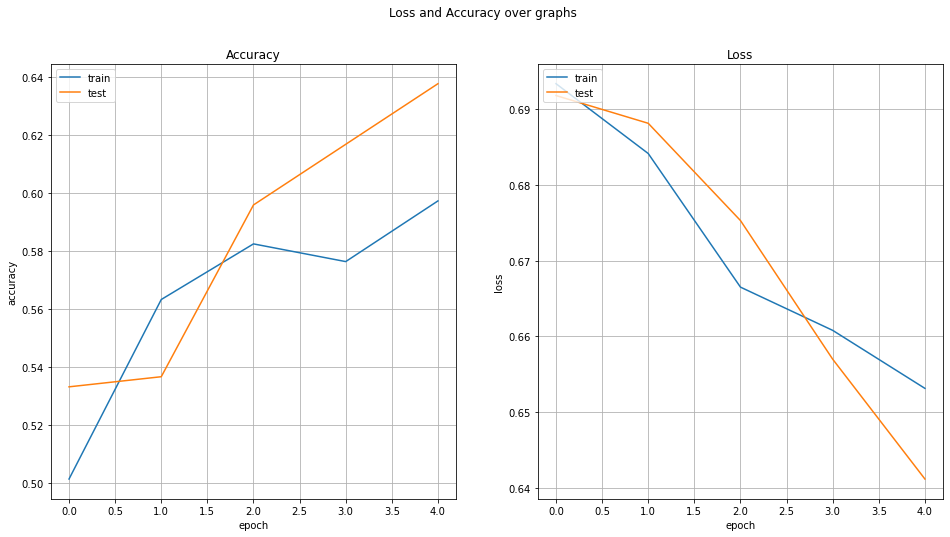

In [233]:
# Plot the loss and accuracy graphs

fig = plt.figure(figsize=(16, 8))
fig.suptitle('Loss and Accuracy over graphs')
    
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.grid(True)
ax.set(xlabel='epoch', ylabel='accuracy', title='Accuracy')
ax.legend(['train','test'], loc='upper left')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.grid(True)
ax.set(xlabel='epoch', ylabel='loss', title='Loss')
ax.legend(['train','test'], loc='upper left')


# Make a prediction

In [234]:
# This is a very small set of completed new data to use to make predictions.
prediction_data = ["this book is fabulous","i hated this book", "the best", "no good", "okay"]
tokenized = tokenizer.texts_to_sequences(prediction_data)
padded = pad_sequences(tokenized, padding='post', maxlen=maxlen)

# Supply this data to each of your models and see how it does.
prediction = model.predict(padded)

# You can call the helper function "to_word_label" to map the output of the model to the name of the class it was predicted to belong to.
to_word_label(prediction)

['negative', 'negative', 'negative', 'negative', 'negative']